![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Satellite imagery

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

### Task:

Set up a google earth engine workflow to display satellite images of a location (or region) of your choosing.

In [42]:
import ee 
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-ebuehler1996')

In [43]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

# Define the location and create a red box around it.
location = ee.Geometry.Point([7.925022563514017, 49.920937991529186])
rectangle = location.buffer(50).bounds()  # Buffer by 50m radius

# Load a high-resolution satellite image.
image_collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(location) \
    .filterDate('2022-01-01', '2022-12-31') \
    .sort('CLOUD_COVERAGE_ASSESSMENT', True)  # Sort by cloud coverage for clearer images

# Take the first image from the collection (least cloudy)
image = image_collection.first()

# Display parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Visualize the image with a red box.
Map = geemap.Map(center=[49.920937991529186, 7.925022563514017], zoom=14)
Map.addLayer(image, vis_params, 'RGB')
Map.addLayer(rectangle, {'color': 'red'}, 'Rectangle')
#Map.centerObject(rectangle)
Map

Map(center=[49.920937991529186, 7.925022563514017], controls=(WidgetControl(options=['position', 'transparent_…

### Task:

Show a time series plot of the average summer temperature in celsius at your location. To do so, choose a relevant data sets from: https://developers.google.com/earth-engine/datasets/

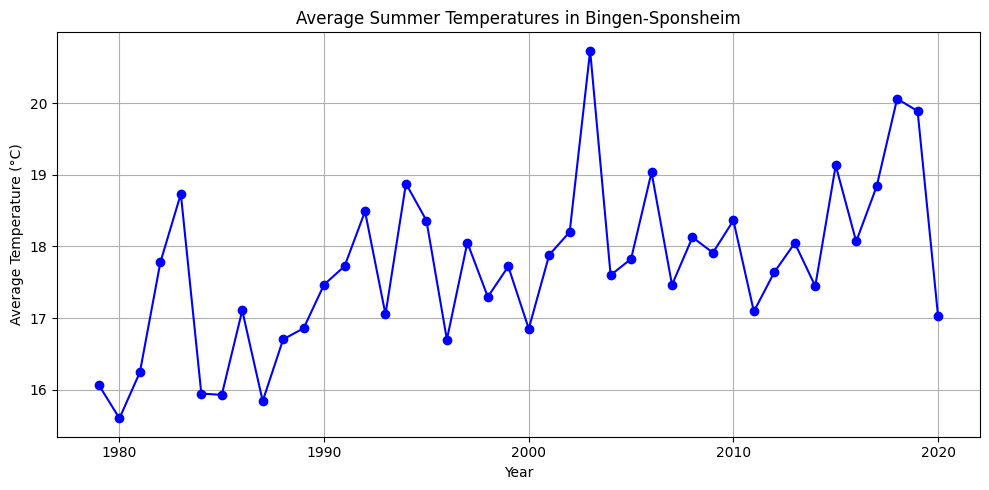

In [44]:
import ee
ee.Initialize()
import matplotlib.pyplot as plt

# Define the location
location = ee.Geometry.Point([7.925022563514017, 49.920937991529186])

# Define the time period
start_year = 1978
end_year = 2021

# Load the ECMWF/ERA5 Monthly dataset
dataset = ee.ImageCollection('ECMWF/ERA5/MONTHLY') \
    .filterBounds(location) \
    .filterDate(f'{start_year}-01-01', f'{end_year}-12-31') \
    .select('mean_2m_air_temperature')

# Filter the dataset for summer months (June, July, August)
summer_months = dataset.filter(ee.Filter.calendarRange(6, 8, 'month'))

# Calculate the average temperature for each summer month and handle null values
def summer_mean(image):
    year = ee.Date(image.get('system:time_start')).get('year')
    mean_temp = image.reduceRegion(
        reducer=ee.Reducer.mean(), 
        geometry=location, 
        scale=1000
    ).get('mean_2m_air_temperature')
    return ee.Algorithms.If(mean_temp, ee.Feature(None, {'mean_temperature': mean_temp, 'year': year}), None)

summer_mean_series = summer_months.map(summer_mean).filter(ee.Filter.notNull(['mean_temperature']))

# Aggregate the summer temperatures by year and handle null values
def aggregate_by_year(year):
    filtered = summer_mean_series.filter(ee.Filter.eq('year', year))
    mean_temp = filtered.aggregate_mean('mean_temperature')
    return ee.Algorithms.If(mean_temp, ee.Feature(None, {'year': year, 'mean_temperature': mean_temp}), None)

years = ee.List.sequence(start_year, end_year)
annual_summer_mean_series = ee.FeatureCollection(years.map(lambda year: aggregate_by_year(year))).filter(ee.Filter.notNull(['mean_temperature']))

# Convert the results to a list for plotting
temperature_list = annual_summer_mean_series.reduceColumns(
    ee.Reducer.toList(2), 
    ['mean_temperature', 'year']
).get('list')

temperature_data = ee.List(temperature_list).getInfo()  # Getting data to client-side for plotting
temperature_data = sorted(temperature_data, key=lambda x: x[1])

# Extracting temperature values and years
years = [int(x[1]) for x in temperature_data]
temperature_values = [x[0] - 273.15 for x in temperature_data]  # Converting from Kelvin to Celsius

# Plot the average summer temperatures using Matplotlib
plt.figure(figsize=(10, 5))
plt.plot(years, temperature_values, marker='o', linestyle='-', color='blue')
plt.title('Average Summer Temperatures in Bingen-Sponsheim')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Task:

Discuss potential data quality issues and solutions. Do the results (temperatures) change if you employ a BAP composition? Add another line to the time series plot, displaying temperatures extracted from the BAP composites.

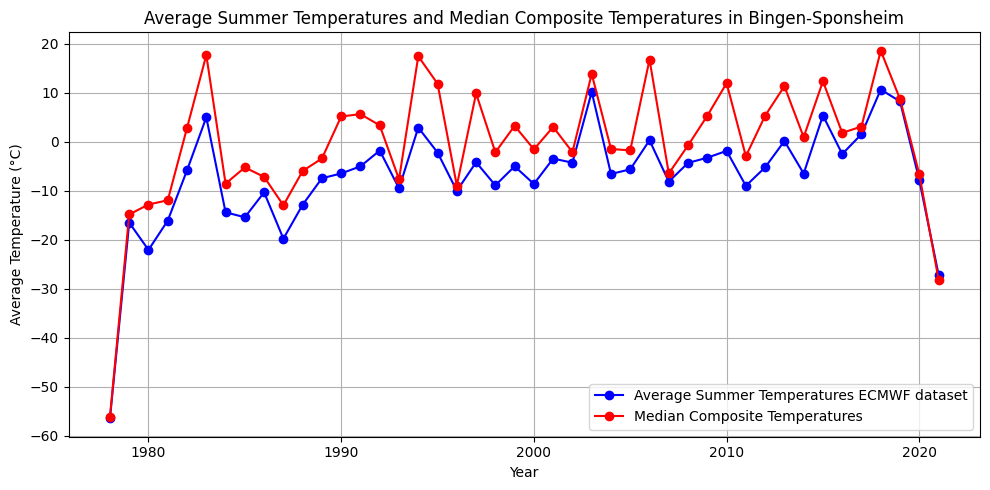

In [56]:
import ee
import geemap
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize()

# Define the location
location = ee.Geometry.Point([7.925022563514017, 49.920937991529186])

# Define the time period
start_year = 1978
end_year = 2021

# Function to rename bands in an ImageCollection
def rename_bands(image):
    return image.rename(['temperature'])

# Load the ECMWF/ERA5 Monthly dataset and rename the temperature band
dataset1 = ee.ImageCollection('ECMWF/ERA5/MONTHLY') \
    .filterBounds(location) \
    .filterDate(f'{start_year}-01-01', f'{end_year}-12-31') \
    .select('mean_2m_air_temperature') \
    .map(rename_bands)

# Load the TerraClimate dataset for monthly temperature and rename the temperature band
dataset2 = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE') \
    .filterBounds(location) \
    .filterDate(f'{start_year}-01-01', f'{end_year}-12-31') \
    .select('tmmx') \
    .map(rename_bands)

# Combine the datasets into one ImageCollection
combined_dataset = dataset1.merge(dataset2)

# Filter the combined dataset for summer months (June, July, August)
summer_months = combined_dataset.filter(ee.Filter.calendarRange(6, 8, 'month'))

# Median Composite for summer months
def get_median_composite(year):
    start_date = ee.Date.fromYMD(year, 6, 1)
    end_date = start_date.advance(3, 'month')
    summer_images = summer_months.filterDate(start_date, end_date)
    median_composite = summer_images.median()
    mean_temp = median_composite.reduceRegion(
        reducer=ee.Reducer.mean(), 
        geometry=location, 
        scale=1000
    ).get('temperature')
    return ee.Algorithms.If(mean_temp, ee.Feature(None, {'year': year, 'mean_temperature': mean_temp}), None)

years = ee.List.sequence(start_year, end_year)
median_composite_series = ee.FeatureCollection(years.map(lambda year: get_median_composite(year))).filter(ee.Filter.notNull(['mean_temperature']))

# Convert the median composite results to a list for plotting
median_composite_list = median_composite_series.reduceColumns(
    ee.Reducer.toList(2), 
    ['mean_temperature', 'year']
).get('list')

median_composite_data = ee.List(median_composite_list).getInfo()  # Getting data to client-side for plotting
median_composite_data = sorted(median_composite_data, key=lambda x: x[1])

# Extracting median composite temperature values and years
median_years = [int(x[1]) for x in median_composite_data]
median_temperature_values = [x[0] - 273.15 for x in median_composite_data]  # Converting from Kelvin to Celsius


# Extracting temperature values and years
years = []
temperature_values = []

for temp, year in temperature_data:
    years.append(int(year))
    temperature_values.append(temp - 273.15)  # Convert from Kelvin to Celsius

# Plot both average summer temperatures and median composite temperatures using Matplotlib
plt.figure(figsize=(10, 5))
plt.plot(years, temperature_values, marker='o', linestyle='-', color='blue', label='Average Summer Temperatures ECMWF dataset')
plt.plot(median_years, median_temperature_values, marker='o', linestyle='-', color='red', label='Median Composite Temperatures')
plt.title('Average Summer Temperatures and Median Composite Temperatures in Bingen-Sponsheim')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


